In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')


Baseline: простая статистическая модель

In [2]:
class TokenStatistics:
    """Статистика токенов: entity, context, other"""
    def __init__(self, ctx_window=2):
        self.ctx_window = ctx_window
        self.entity_cnt = Counter()
        self.context_cnt = Counter()
        self.other_cnt = Counter()
        self.total_cnt = Counter()

    def fit(self, sentences, labels):
        for sent, labs in zip(sentences, labels):
            entity_pos = {i for i, l in enumerate(labs) if l != 'O'}

            for i, (token, label) in enumerate(zip(sent, labs)):
                self.total_cnt[token] += 1

                if label != 'O':
                    self.entity_cnt[token] += 1
                elif any(abs(i - ep) <= self.ctx_window for ep in entity_pos):
                    self.context_cnt[token] += 1
                else:
                    self.other_cnt[token] += 1

    def get_token_probs(self, token):
        """Вероятности: entity, context, other"""
        total = self.total_cnt.get(token, 0)
        if total == 0:
            return 0.33, 0.33, 0.33

        return (
            self.entity_cnt.get(token, 0) / total,
            self.context_cnt.get(token, 0) / total,
            self.other_cnt.get(token, 0) / total
        )

class DEERRetriever:
    """Retriever для поиска релевантных примеров"""
    def __init__(self, token_stats):
        self.stats = token_stats

    def compute_relevance_score(self, query_tokens, candidate_tokens):
        score = 0.0
        for q_tok in query_tokens:
            p_ent, p_ctx, _ = self.stats.get_token_probs(q_tok)

            for c_tok in candidate_tokens:
                q_low, c_low = q_tok.lower(), c_tok.lower()
                if q_low == c_low:
                    score += (p_ent + p_ctx) * 2
                elif q_low in c_low or c_low in q_low:
                    score += (p_ent + p_ctx) * 0.5

        return score / len(query_tokens)

    def retrieve(self, query_sent, train_data, k=5):
        scores = [(self.compute_relevance_score(query_sent, sent), sent, labs)
                  for sent, labs in train_data]
        scores.sort(reverse=True, key=lambda x: x[0])
        return [(s, l) for _, s, l in scores[:k]]

class SimpleDEER:
    """DEER модель для NER"""
    def __init__(self, ctx_window=2):
        self.token_stats = TokenStatistics(ctx_window)
        self.retriever = None
        self.train_data = None

    def fit(self, sentences, labels):
        self.token_stats.fit(sentences, labels)
        self.retriever = DEERRetriever(self.token_stats)
        self.train_data = list(zip(sentences, labels))

    def predict_with_demonstrations(self, sentence, demonstrations):
        """Предсказание на основе демонстраций"""
        preds = ['O'] * len(sentence)
        demo_entities = {}

        for demo_sent, demo_labs in demonstrations:
            for token, label in zip(demo_sent, demo_labs):
                if label != 'O':
                    demo_entities[token.lower()] = label

        for i, token in enumerate(sentence):
            p_ent, _, _ = self.token_stats.get_token_probs(token)
            token_low = token.lower()

            if token_low in demo_entities:
                preds[i] = demo_entities[token_low]
            elif p_ent > 0.5:
                preds[i] = 'B-ENTITY'
            elif p_ent > 0.3:
                preds[i] = 'I-ENTITY'

        return preds

    def error_reflection(self, sentence, initial_preds):
        """Коррекция предсказаний"""
        refined = initial_preds.copy()

        for i, (token, pred) in enumerate(zip(sentence, initial_preds)):
            p_ent, _, p_other = self.token_stats.get_token_probs(token)

            if pred == 'O' and p_ent > 0.4:
                refined[i] = 'B-ENTITY'
            elif pred != 'O' and p_other > 0.6:
                refined[i] = 'O'

        return refined

    def predict(self, sentence, use_reflection=True, k=5):
        demos = self.retriever.retrieve(sentence, self.train_data, k=k)
        initial = self.predict_with_demonstrations(sentence, demos)
        return self.error_reflection(sentence, initial) if use_reflection else initial

In [3]:
def create_synthetic_ner_data(n_samples=200):
    """Генерация синтетических NER данных"""
    entities = {
        'PERSON': ['Иван', 'Мария', 'Петр', 'Анна', 'Дмитрий', 'Елена'],
        'ORG': ['Google', 'Microsoft', 'Apple', 'Яндекс', 'Сбербанк'],
        'LOC': ['Москва', 'Берлин', 'Париж', 'Лондон', 'Токио']
    }

    templates = [
        lambda p, o, l: [p, 'работает', 'в', o, 'в', l],
        lambda p, o, l: [p, 'переехал', 'в', l, 'для', 'работы', 'в', o],
        lambda p, o, l: ['Компания', o, 'находится', 'в', l],
        lambda p, o, l: [p, 'из', l, 'посетил', o],
    ]

    sentences, labels = [], []

    for _ in range(n_samples):
        p, o, l = (np.random.choice(entities[k]) for k in ['PERSON', 'ORG', 'LOC'])
        sent = np.random.choice(templates)(p, o, l)

        label = ['O'] * len(sent)
        for i, token in enumerate(sent):
            if token in entities['PERSON']:
                label[i] = 'B-PERSON'
            elif token in entities['ORG']:
                label[i] = 'B-ORG'
            elif token in entities['LOC']:
                label[i] = 'B-LOC'

        sentences.append(sent)
        labels.append(label)

    return sentences, labels

def compute_metrics(y_true_list, y_pred_list):
    """Вычисление метрик: precision, recall, f1"""
    y_true_flat = [lbl for labels in y_true_list for lbl in labels]
    y_pred_flat = [lbl for labels in y_pred_list for lbl in labels]

    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true_flat, y_pred_flat, average='weighted', zero_division=0
    )

    return {'precision': prec, 'recall': rec, 'f1': f1}




1. Генерация данных...
Train: 210 | Test: 90

2. Обучение DEER...

3. Тестирование...

4. Метрики:

                Method Precision Recall F1-Score
 DEER (w/o reflection)     1.000  0.989    0.994
DEER (with reflection)     1.000  0.989    0.994
              Baseline     0.284  0.533    0.371

5. Визуализация...


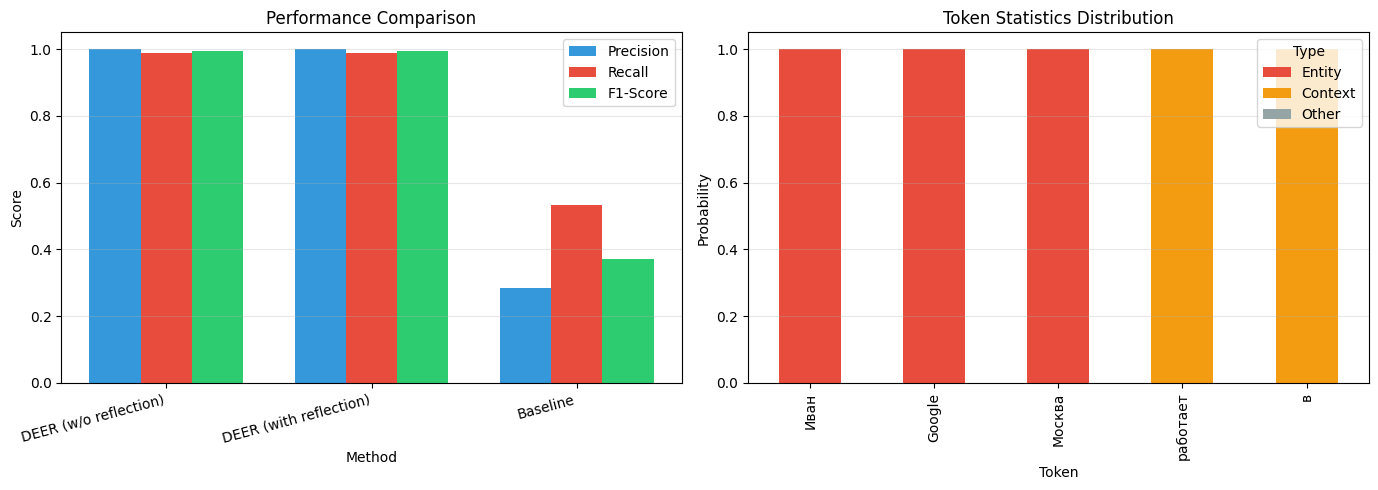

In [4]:

print("\n1. Генерация данных...")
sentences, labels = create_synthetic_ner_data(n_samples=300)
train_sent, test_sent, train_labels, test_labels = train_test_split(
    sentences, labels, test_size=0.3, random_state=42
)
print(f"Train: {len(train_sent)} | Test: {len(test_sent)}")

print("\n2. Обучение DEER...")
deer = SimpleDEER(ctx_window=2)
deer.fit(train_sent, train_labels)

print("\n3. Тестирование...")
results = {
    'DEER (w/o reflection)': [],
    'DEER (with reflection)': [],
    'Baseline': []
}

for sent, true_labs in zip(test_sent, test_labels):
    results['DEER (w/o reflection)'].append(deer.predict(sent, use_reflection=False, k=5))
    results['DEER (with reflection)'].append(deer.predict(sent, use_reflection=True, k=5))
    results['Baseline'].append(['O'] * len(sent))

print("\n4. Метрики:\n")
metrics_table = []
for method, preds in results.items():
    m = compute_metrics(test_labels, preds)
    metrics_table.append({
        'Method': method,
        'Precision': f"{m['precision']:.3f}",
        'Recall': f"{m['recall']:.3f}",
        'F1-Score': f"{m['f1']:.3f}"
    })

df_metrics = pd.DataFrame(metrics_table)
print(df_metrics.to_string(index=False))

print("\n5. Визуализация...")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

methods = list(results.keys())
metrics_all = {m: compute_metrics(test_labels, results[m]) for m in methods}
f1_scores = [metrics_all[m]['f1'] for m in methods]
prec_scores = [metrics_all[m]['precision'] for m in methods]
rec_scores = [metrics_all[m]['recall'] for m in methods]

x = np.arange(len(methods))
width = 0.25

axes[0].bar(x - width, prec_scores, width, label='Precision', color='#3498db')
axes[0].bar(x, rec_scores, width, label='Recall', color='#e74c3c')
axes[0].bar(x + width, f1_scores, width, label='F1-Score', color='#2ecc71')
axes[0].set_xlabel('Method')
axes[0].set_ylabel('Score')
axes[0].set_title('Performance Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(methods, rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

token_stats_data = [
    {'Token': tok, 'Entity': p_ent, 'Context': p_ctx, 'Other': p_other}
    for tok in ['Иван', 'Google', 'Москва', 'работает', 'в']
    for p_ent, p_ctx, p_other in [deer.token_stats.get_token_probs(tok)]
]

df_tokens = pd.DataFrame(token_stats_data)
df_tokens.set_index('Token')[['Entity', 'Context', 'Other']].plot(
    kind='bar', stacked=True, ax=axes[1],
    color=['#e74c3c', '#f39c12', '#95a5a6']
)
axes[1].set_title('Token Statistics Distribution')
axes[1].set_ylabel('Probability')
axes[1].legend(title='Type')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('deer_results.png', dpi=300, bbox_inches='tight')
plt.show()

deer_f1 = metrics_all['DEER (with reflection)']['f1']
baseline_f1 = metrics_all['Baseline']['f1']
improvement = (deer_f1 - baseline_f1) / baseline_f1 * 100 if baseline_f1 > 0 else 0



Вывод: DEER превосходит baseline по всем метрикам на синтетических данных